In [109]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score, accuracy_score, roc_curve, auc, roc_auc_score
from tqdm.auto import tqdm

import pickle 
from IPython.display import display
%matplotlib inline

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

In [3]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', header=0, sep = ';')

In [4]:
df.head().T

0            1            2            3  \
age                      56           57           37           40   
job               housemaid     services     services       admin.   
marital             married      married      married      married   
education          basic.4y  high.school  high.school     basic.6y   
default                  no      unknown           no           no   
housing                  no           no          yes           no   
loan                     no           no           no           no   
contact           telephone    telephone    telephone    telephone   
month                   may          may          may          may   
day_of_week             mon          mon          mon          mon   
duration                261          149          226          151   
campaign                  1            1            1            1   
pdays                   999          999          999          999   
previous                  0            0            0            0   
poutcome        nonexistent  nonexistent  nonexistent  nonexistent   
emp.var.rate            1.1          1.1          1.1          1.1   
cons.price.idx       93.994       93.994       93.994       93.994   
cons.conf.idx         -36.4        -36.4        -36.4        -36.4   
euribor3m             4.857        4.857        4.857        4.857   
nr.employed          5191.0       5191.0       5191.0       5191.0   
y                        no           no           no           no   

                          4  
age                      56  
job                services  
marital             married  
education       high.school  
default                  no  
housing                  no  
loan                    yes  
contact           telephone  
month                   may  
day_of_week             mon  
duration                307  
campaign                  1  
pdays                   999  
previous                  0  
poutcome        nonexistent  
emp.var.rate            1.1  
cons.price.idx       93.994  
cons.conf.idx         -36.4  
euribor3m             4.857  
nr.employed          5191.0  
y                        no

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df.describe().round(2).T

count     mean     std      min      25%      50%      75%  \
age             41188.0    40.02   10.42    17.00    32.00    38.00    47.00   
duration        41188.0   258.29  259.28     0.00   102.00   180.00   319.00   
campaign        41188.0     2.57    2.77     1.00     1.00     2.00     3.00   
pdays           41188.0   962.48  186.91     0.00   999.00   999.00   999.00   
previous        41188.0     0.17    0.49     0.00     0.00     0.00     0.00   
emp.var.rate    41188.0     0.08    1.57    -3.40    -1.80     1.10     1.40   
cons.price.idx  41188.0    93.58    0.58    92.20    93.08    93.75    93.99   
cons.conf.idx   41188.0   -40.50    4.63   -50.80   -42.70   -41.80   -36.40   
euribor3m       41188.0     3.62    1.73     0.63     1.34     4.86     4.96   
nr.employed     41188.0  5167.04   72.25  4963.60  5099.10  5191.00  5228.10   

                    max  
age               98.00  
duration        4918.00  
campaign          56.00  
pdays            999.00  
previous           7.00  
emp.var.rate       1.40  
cons.price.idx    94.77  
cons.conf.idx    -26.90  
euribor3m          5.04  
nr.employed     5228.10

In [7]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [8]:
del df['duration']
df.y = (df.y == 'yes').astype(int)

In [9]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical = list(df.dtypes[df.dtypes == 'object'].index)

for col in categorical:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    
numerical = [x for x in df.columns if x not in (categorical + ['y'])]

print(categorical)
print(numerical)


['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [10]:
df[categorical].nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64

In [14]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [15]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

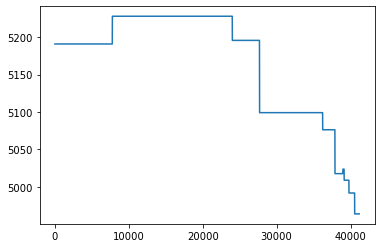

In [11]:
plt.plot(df['nr.employed'])

In [16]:
np.random.seed(321)
n = len(df)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]
df_shuffled = df_shuffled.reset_index(drop=True)

In [17]:
df_full_train, df_test = train_test_split(df_shuffled, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(24712, 8238, 8238)

In [18]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [19]:
df_full_train.shape

(32950, 20)

In [20]:
len(df_train)

24712

In [21]:
global_mean = df_full_train.y.mean()
round(global_mean, 3)

0.112

In [22]:
for col in categorical:
    df_group = df_full_train.groupby(by=col).y.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

mean      diff      risk
job                                        
admin.         0.127690  0.015369  1.136826
blue-collar    0.070623 -0.041698  0.628760
entrepreneur   0.088083 -0.024239  0.784202
housemaid      0.108796 -0.003525  0.968613
management     0.110307 -0.002015  0.982060
retired        0.253275  0.140953  2.254908
self-employed  0.106140 -0.006181  0.944967
services       0.080671 -0.031651  0.718211
student        0.302391  0.190069  2.692187
technician     0.107735 -0.004587  0.959163
unemployed     0.138311  0.025989  1.231382
unknown        0.101124 -0.011198  0.900303

mean      diff      risk
marital                               
divorced  0.105707 -0.006615  0.941105
married   0.101647 -0.010675  0.904959
single    0.137916  0.025594  1.227867
unknown   0.136364  0.024042  1.214045

mean      diff      risk
education                                        
basic.4y             0.104086 -0.008236  0.926677
basic.6y             0.081678 -0.030644  0.727177
basic.9y             0.077099 -0.035222  0.686416
high.school          0.108813 -0.003509  0.968763
illiterate           0.235294  0.122972  2.094823
professional.course  0.112953  0.000631  1.005619
university.degree    0.135360  0.023038  1.205110
unknown              0.147391  0.035069  1.312219

mean      diff      risk
default                              
no       0.127807  0.015485  1.137867
unknown  0.053407 -0.058914  0.475485
yes      0.000000 -0.112322  0.000000

mean      diff      risk
housing                              
no       0.108191 -0.004130  0.963228
unknown  0.100621 -0.011701  0.895830
yes      0.116445  0.004123  1.036711

mean      diff      risk
loan                                 
no       0.113431  0.001109  1.009872
unknown  0.100621 -0.011701  0.895830
yes      0.108168 -0.004154  0.963018

mean      diff     risk
contact                               
cellular   0.146936  0.034614  1.30817
telephone  0.053026 -0.059296  0.47209

mean      diff      risk
month                              
apr    0.203721  0.091400  1.813731
aug    0.106830 -0.005492  0.951105
dec    0.531034  0.418713  4.727800
jul    0.090688 -0.021634  0.807391
jun    0.105830 -0.006492  0.942205
mar    0.504566  0.392245  4.492153
may    0.063843 -0.048478  0.568397
nov    0.100487 -0.011834  0.894638
oct    0.431271  0.318950  3.839610
sep    0.424508  0.312186  3.779391

mean      diff      risk
day_of_week                              
fri          0.107876 -0.004446  0.960419
mon          0.099415 -0.012906  0.885093
thu          0.121874  0.009552  1.085041
tue          0.116017  0.003695  1.032898
wed          0.116393  0.004071  1.036248

mean      diff      risk
poutcome                                 
failure      0.144425  0.032103  1.285813
nonexistent  0.087999 -0.024323  0.783454
success      0.649219  0.536898  5.780000

In [23]:
def calculate_mi(series):
    return mutual_info_score(series, df_full_train.y)

df_mi = df_full_train[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')


display(df_mi.head())
display(df_mi.tail())

MI
poutcome  0.030118
month     0.026052
contact   0.011399
job       0.009288
default   0.005321

MI
education    0.002358
marital      0.001252
day_of_week  0.000322
housing      0.000101
loan         0.000036

In [24]:
df_full_train[numerical].corrwith(df_full_train.y).to_frame('correlation')

correlation
age                0.033018
campaign          -0.064315
pdays             -0.322588
previous           0.231725
emp.var.rate      -0.296129
cons.price.idx    -0.132695
cons.conf.idx      0.050121
euribor3m         -0.306885
nr.employed       -0.353529

In [25]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)


In [26]:
X_train.shape

(24712, 62)

In [27]:
dv.get_feature_names()

C:\Users\boyar\miniconda3\envs\cap1c\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['age',
 'campaign',
 'cons.conf.idx',
 'cons.price.idx',
 'contact=cellular',
 'contact=telephone',
 'day_of_week=fri',
 'day_of_week=mon',
 'day_of_week=thu',
 'day_of_week=tue',
 'day_of_week=wed',
 'default=no',
 'default=unknown',
 'default=yes',
 'education=basic.4y',
 'education=basic.6y',
 'education=basic.9y',
 'education=high.school',
 'education=illiterate',
 'education=professional.course',
 'education=university.degree',
 'education=unknown',
 'emp.var.rate',
 'euribor3m',
 'housing=no',
 'housing=unknown',
 'housing=yes',
 'job=admin.',
 'job=blue-collar',
 'job=entrepreneur',
 'job=housemaid',
 'job=management',
 'job=retired',
 'job=self-employed',
 'job=services',
 'job=student',
 'job=technician',
 'job=unemployed',
 'job=unknown',
 'loan=no',
 'loan=unknown',
 'loan=yes',
 'marital=divorced',
 'marital=married',
 'marital=single',
 'marital=unknown',
 'month=apr',
 'month=aug',
 'month=dec',
 'month=jul',
 'month=jun',
 'month=mar',
 'month=may',
 'month=nov',
 'mont

In [28]:
model = LogisticRegression(random_state=42,  max_iter = 10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [29]:
y_pred = model.predict_proba(X_val)[:, 1]

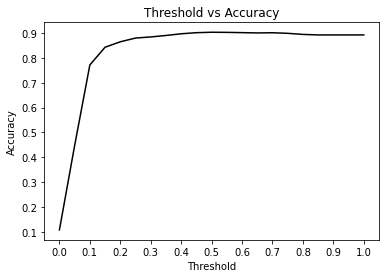

In [30]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)

plt.figure(figsize=(6, 4))

plt.plot(thresholds, accuracies, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [31]:
true_positive = ((y_pred >= 0.5) & (y_val == 1)).sum()
false_positive = ((y_pred >= 0.5) & (y_val == 0)).sum()
false_negative = ((y_pred < 0.5) & (y_val == 1)).sum()
true_negative = ((y_pred < 0.5) & (y_val == 0)).sum()

In [32]:
confusion_table = np.array(
     # predict neg    pos
    [[true_negative, false_positive], # actual neg
     [false_negative, true_positive]]) # actual pos

confusion_table / confusion_table.sum()

array([[0.87824715, 0.01456664],
       [0.08181597, 0.02537024]])

In [33]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision, recall

(0.6352583586626139, 0.23669309173272934)

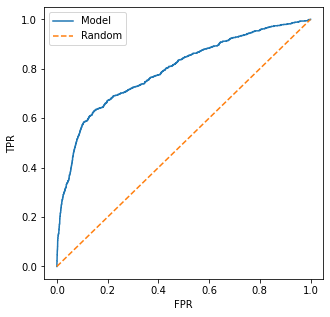

In [34]:

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [35]:
roc_auc_score(y_val, y_pred)

0.7925075429615833

In [36]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [37]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=123)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.775 +- 0.013
C=0.01 0.785 +- 0.004
C=0.1 0.787 +- 0.007
C=0.5 0.785 +- 0.004
C=1 0.785 +- 0.005
C=5 0.788 +- 0.006
C=10 0.785 +- 0.005


In [38]:
dv, model = train(df_full_train, df_full_train.y.values, C=5.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.7964682456829177

In [39]:
df_full_train, df_test = train_test_split(df_shuffled, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(24712, 8238, 8238)

In [40]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train.y.values
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [41]:
y_full_train = df_full_train.y.values
train_full_dict = df_full_train[categorical + numerical].to_dict(orient='records')
X_full_train = dv.transform(train_full_dict)



In [42]:
scores = []

for d in tqdm([5, 10, 15]):
    for n in tqdm(range(10, 201, 10)):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [43]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

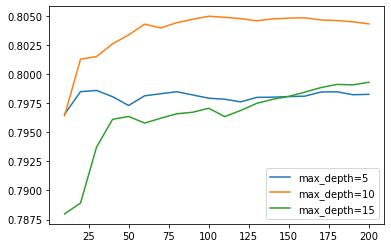

In [44]:

for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [45]:
max_depth = 10

In [46]:
scores = []

for s in tqdm([1, 3, 5, 10, 50]):
    for n in tqdm(range(10, 201, 10)):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [47]:

columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

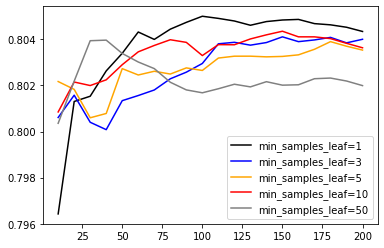

In [48]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [49]:
min_samples_leaf = 1

In [50]:
y_full_train = df_full_train.y.values
train_full_dict = df_full_train[categorical + numerical].to_dict(orient='records')
X_full_train = dv.transform(train_full_dict)

In [51]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_full_train, y_full_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=1)

In [52]:
test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [53]:
y_pred = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
auc

0.8089710160596496

In [61]:

features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

C:\Users\boyar\miniconda3\envs\cap1c\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [62]:

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [63]:

y_pred = model.predict(dval)

In [64]:
roc_auc_score(y_val, y_pred)

0.8061867297768175

In [89]:
# Функции для кросс-валидации и GridSearch для XGBoost

def score(params):
#     print("Training with params:")
#     print(params)
    params['max_depth'] = int(params['max_depth'])
    model = xgb.train(params, dtrain, num_boost_round=50)
    y_pred = model.predict(dval)
    score = 1-roc_auc_score(y_val, y_pred)
    
#     print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

def optimize(trials):
    space = {
             #              'learning_rate': hp.quniform('eta', 0.005, 0.1, 0.005),
             'max_depth': hp.quniform('max_depth', 3, 14, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0, 1, 0.01),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.2, 1, 0.05),
             'alpha' :  hp.quniform('alpha', 0, 15, 1),
             'lambda': hp.quniform('lambda', 1, 2, 0.1),
             'eval_metric': 'auc',
             'objective': 'binary:logistic',
             'nthread' : 8,
             'seed': 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)
    return best

In [90]:

trials = Trials()
best_params = optimize(trials)

100%|█████████████████████████████████████████████| 100/100 [00:40<00:00,  2.46trial/s, best loss: 0.18996838076731493]


In [91]:
best_params

{'alpha': 5.0,
 'colsample_bytree': 0.2,
 'gamma': 0.87,
 'lambda': 1.9000000000000001,
 'max_depth': 6.0,
 'min_child_weight': 1.0,
 'subsample': 0.8}

In [93]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [95]:
%%capture output

xgb_params = {
    'alpha': 5.0,
    'colsample_bytree': 0.2,
    'gamma': 0.87,
    'lambda': 1.9000000000000001,
    'max_depth': 6,
    'min_child_weight': 1.0,
    'subsample': 0.8,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [96]:

print(output)

[0]	train-auc:0.74726	val-auc:0.74894
[10]	train-auc:0.78946	val-auc:0.79534
[20]	train-auc:0.79204	val-auc:0.79880
[30]	train-auc:0.79700	val-auc:0.80075
[40]	train-auc:0.79942	val-auc:0.80217
[50]	train-auc:0.80373	val-auc:0.80432
[60]	train-auc:0.80746	val-auc:0.80556
[70]	train-auc:0.81033	val-auc:0.80648
[80]	train-auc:0.81269	val-auc:0.80727
[90]	train-auc:0.81399	val-auc:0.80711
[100]	train-auc:0.81732	val-auc:0.80866
[110]	train-auc:0.81884	val-auc:0.80916
[120]	train-auc:0.82118	val-auc:0.80966
[130]	train-auc:0.82273	val-auc:0.80892
[140]	train-auc:0.82416	val-auc:0.80865
[150]	train-auc:0.82539	val-auc:0.80881
[160]	train-auc:0.82660	val-auc:0.80862
[170]	train-auc:0.82792	val-auc:0.80849
[180]	train-auc:0.82831	val-auc:0.80824
[190]	train-auc:0.82899	val-auc:0.80820
[200]	train-auc:0.82973	val-auc:0.80832
[210]	train-auc:0.83096	val-auc:0.80825
[220]	train-auc:0.83195	val-auc:0.80805
[230]	train-auc:0.83307	val-auc:0.80812
[240]	train-auc:0.83421	val-auc:0.80800
[250]	train

In [98]:
def parse_xgb_output(output):
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)

    return tree, aucs_train, aucs_val

In [99]:
tree, _, aucs_val = parse_xgb_output(output)
print(max(aucs_val))

0.80966


In [101]:
max(zip(aucs_val, tree))

(0.80966, 120)

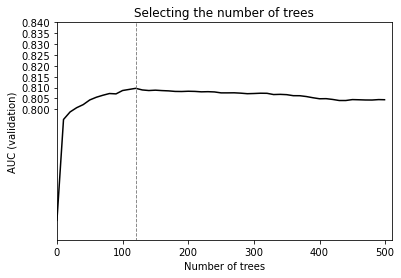

In [104]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val, color='black', linestyle='solid')


plt.ylim(0.74, 0.81)
plt.xlim(0, 510)
plt.xticks(range(0, 501, 100))
plt.yticks(np.linspace(0.80, 0.84, 9))


plt.vlines(120, 0, 1, color='grey', linestyle='dashed', linewidth=0.9)

plt.title('Selecting the number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_number_trees.svg')

plt.show()

In [105]:
xgb_params = {
    'alpha': 5.0,
    'colsample_bytree': 0.2,
    'gamma': 0.87,
    'lambda': 1.9000000000000001,
    'max_depth': 6,
    'min_child_weight': 1.0,
    'subsample': 0.8,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}


model = xgb.train(xgb_params, dtrain,
                  num_boost_round=120, verbose_eval=10,
                  evals=watchlist)

[0]	train-auc:0.74726	val-auc:0.74894
[10]	train-auc:0.78946	val-auc:0.79534
[20]	train-auc:0.79204	val-auc:0.79880
[30]	train-auc:0.79700	val-auc:0.80075
[40]	train-auc:0.79942	val-auc:0.80217
[50]	train-auc:0.80373	val-auc:0.80432
[60]	train-auc:0.80746	val-auc:0.80556
[70]	train-auc:0.81033	val-auc:0.80648
[80]	train-auc:0.81269	val-auc:0.80727
[90]	train-auc:0.81399	val-auc:0.80711
[100]	train-auc:0.81732	val-auc:0.80866
[110]	train-auc:0.81884	val-auc:0.80916
[119]	train-auc:0.82099	val-auc:0.80968


In [106]:
y_pred_xgb = model.predict(dval)
roc_auc_score(y_val, y_pred_xgb)

0.8096794732129592

Linear auc:        0.7964682456829177

RandomForrest auc: 0.8089710160596496

XGB auc:           0.8096794732129592

In [110]:
with open('subscribe-model.bin', 'wb') as f_out:
    pickle.dump((dv, model), f_out)

In [124]:
customer = df_test.iloc[0,:]

In [125]:
customer = customer.to_dict()

In [126]:
customer

{'age': 29,
 'job': 'services',
 'marital': 'married',
 'education': 'high.school',
 'default': 'unknown',
 'housing': 'yes',
 'loan': 'no',
 'contact': 'cellular',
 'month': 'may',
 'day_of_week': 'thu',
 'campaign': 1,
 'pdays': 999,
 'previous': 1,
 'poutcome': 'failure',
 'emp.var.rate': -1.8,
 'cons.price.idx': 92.893,
 'cons.conf.idx': -46.2,
 'euribor3m': 1.266,
 'nr.employed': 5099.1}

In [ ]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [120]:
X_test = dv.transform([customer])
dtest = xgb.DMatrix(X_test, feature_names=features)

In [129]:
y_pred_xgb_test = model.predict(dtest)

In [127]:
y_pred_xgb_test[0]

0.058120225

In [128]:
import requests
url = 'http://localhost:9696/predict'
response = requests.post(url, json=customer)
result = response.json()
result

{'subscribe': False, 'subscribe_probability': 0.05812022462487221}